<a href="https://colab.research.google.com/github/stephenbeckr/time-series-class/blob/main/Demos/TimeSeries_NonstationaryAndARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages("itsmr")
library(itsmr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Real-data examples of nonstationary time series


#### Google stock closing values (2004-2014)

We'll start by plotting it

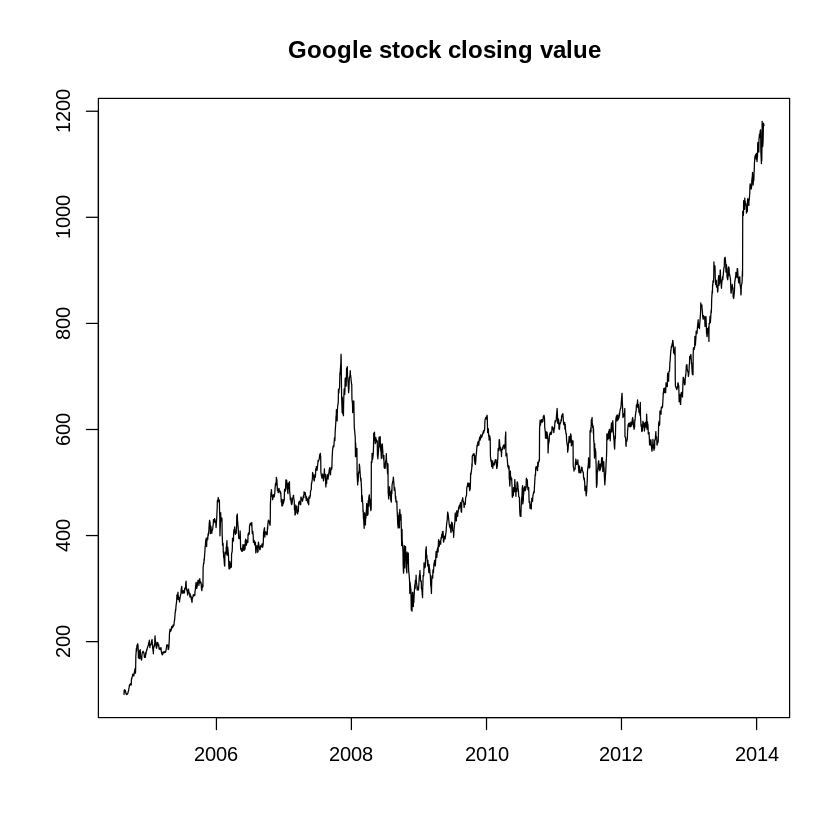

In [26]:
link <- url('https://github.com/stephenbeckr/time-series-class/raw/main/Data/GOOG20042014.csv')
dat <- read.csv(link)
# dat looks like:
# Date,Open,High,Low,Close,Volume,Adj Close
# 2014-02-10,1171.80,1182.40,1169.02,1172.93,1945200,1172.93
# 2014-02-07,1167.63,1177.90,1160.56,1177.44,2636200,1177.44
# ...
# 2004-08-20,101.01,109.08,100.50,108.31,11428600,108.31
# 2004-08-19,100.00,104.06,95.96,100.34,22351900,100.34
dts <- rev(dat[,1])
dates <- as.Date( dts, format="%Y-%m-%d" ) # Convert to nicer datatype

x <- rev(dat[,5])  # take the 5th column ("Close"), and reverse order

plot(dates,x,type="l",xlab="",ylab="",main="Google stock closing value")

Does that look stationary?  No!  There seems to be a trend -- this looks like a random walk more than anything with a constant mean

Let's also look at the ACF, PAC and periodogram (our main tools for visual analysis, other than plotting the time series itself)

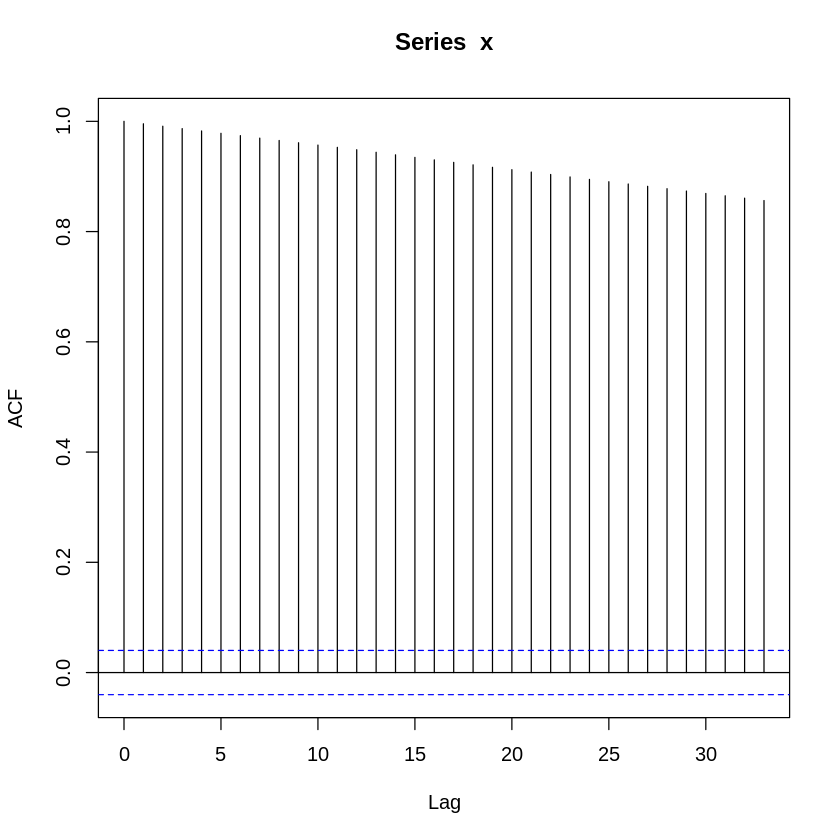

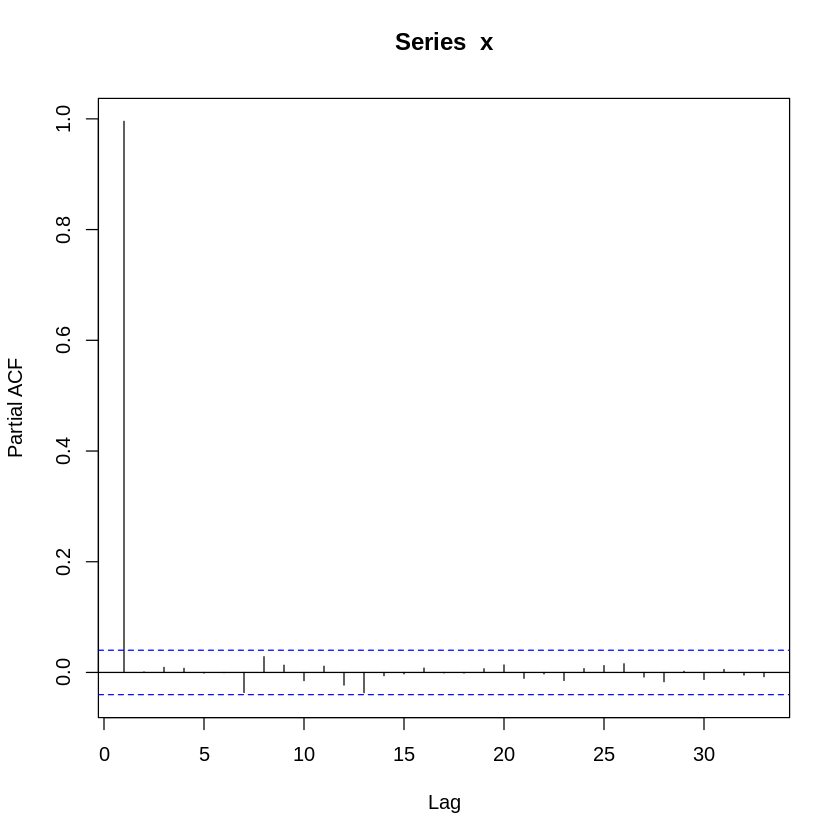

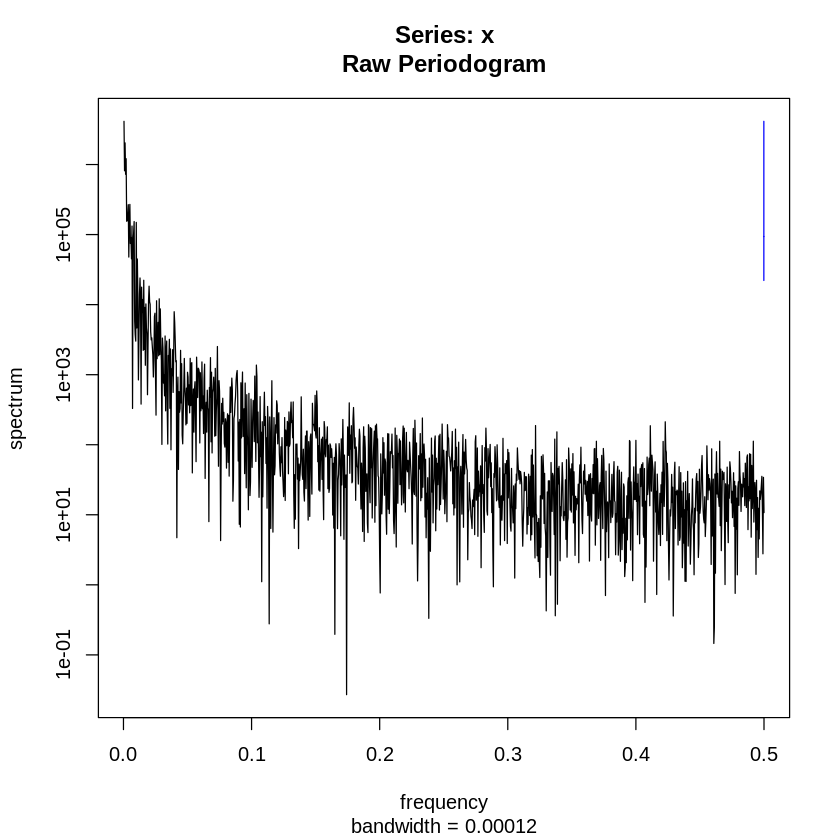

In [27]:
# ACF and PACF
# itsmr::plota(dat) # plots both acf and pacf, but needs ITSMR package (from textbook)
acf(x)
pacf(x)
# Periodogram
spec.pgram(x,log="yes",taper=.1)

The **ACF** was very informative: it shows **very slow** decay, indicating a high degree of correlation. This is probably caused by the trend.

So, if it's not stationary, we can try **differencing** (and if we fit this difference data to an ARMA model, that's like fitting the original data to an ARIMA model)

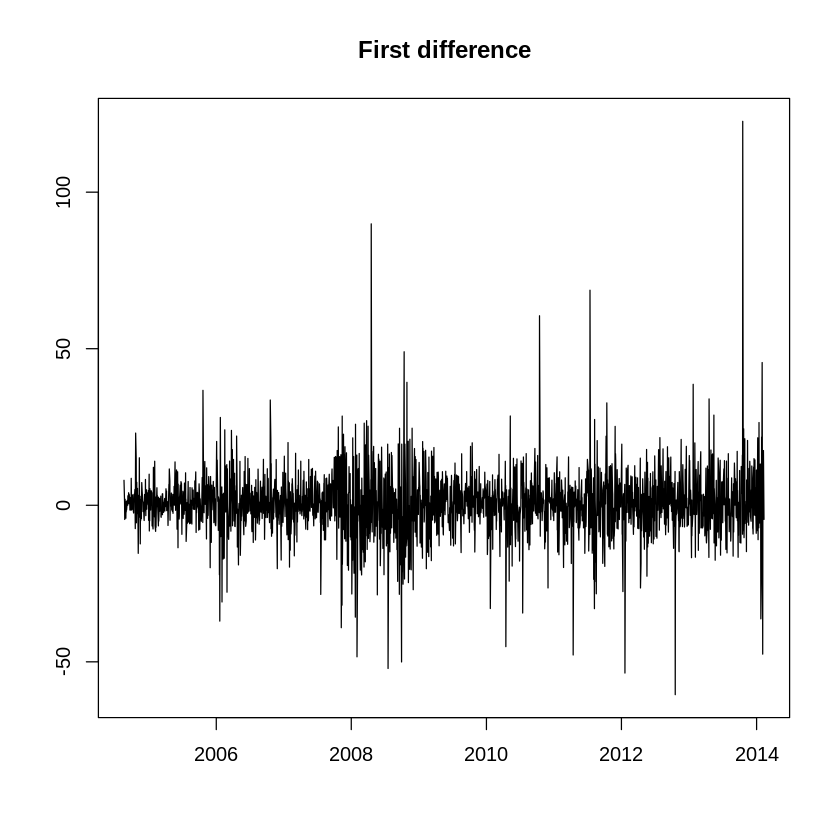

In [30]:
plot(dates[-1],diff(x),type="l",xlab="",ylab="",main="First difference")

It certainly looks much closer to being zero mean now.  Let's also look at the ACF/PACF and periodogram:

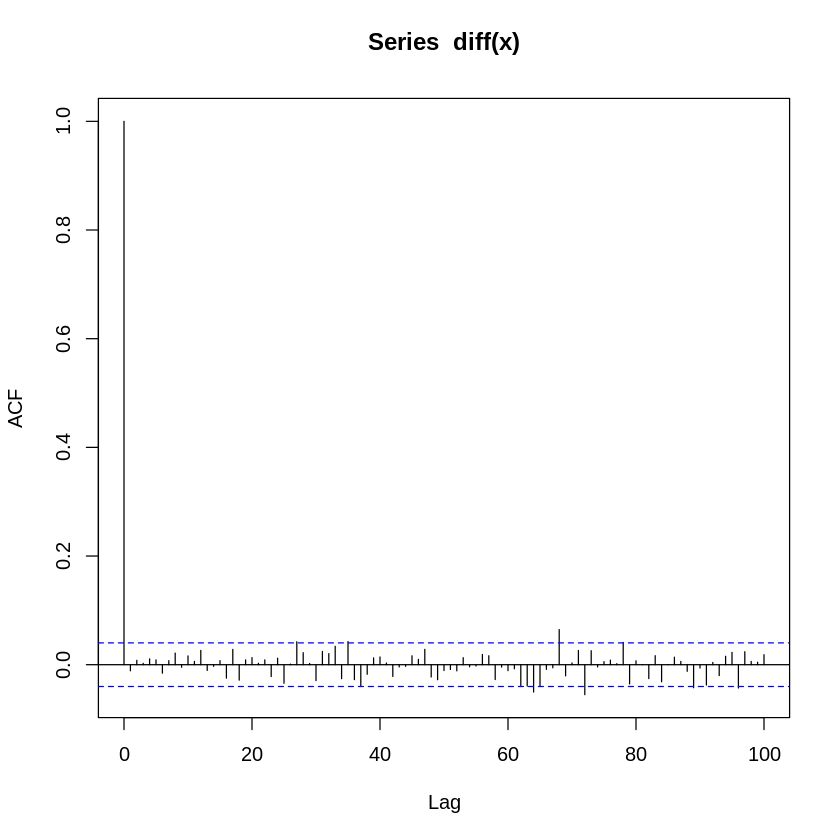

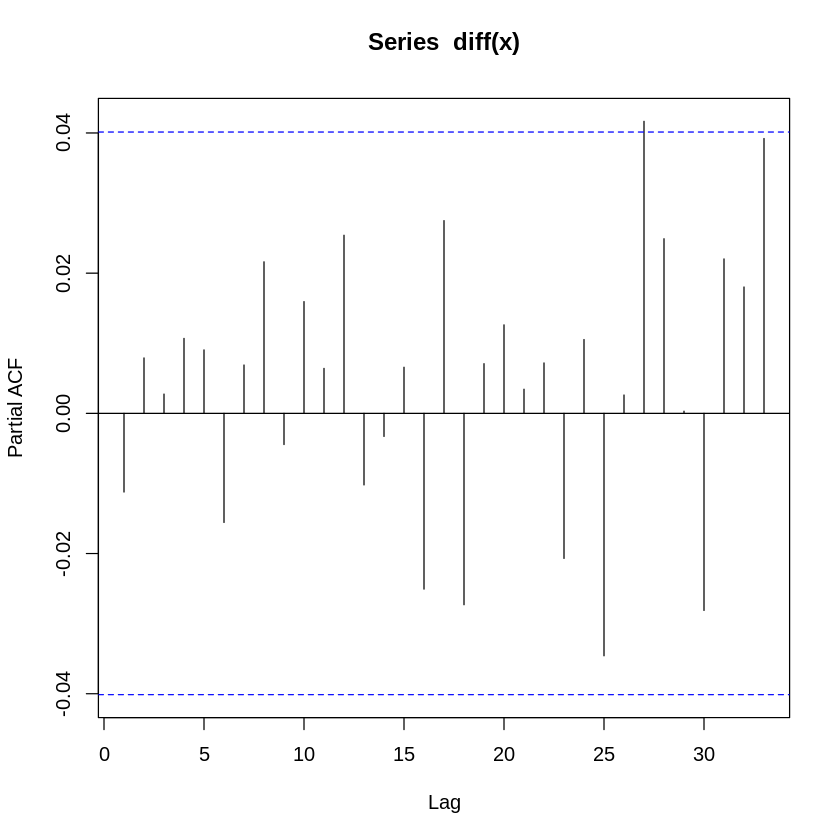

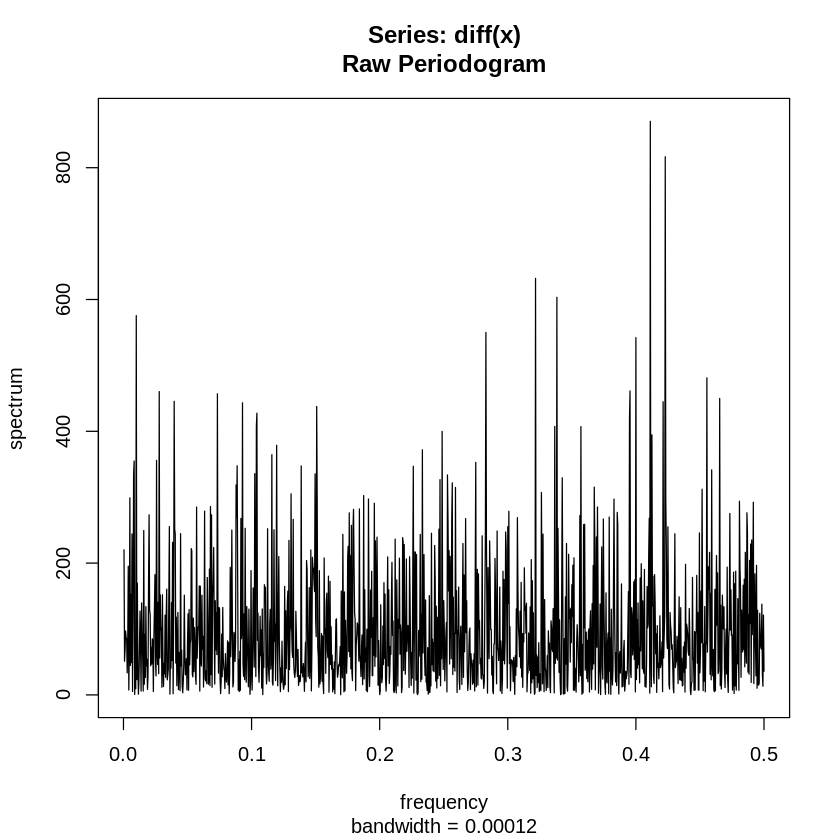

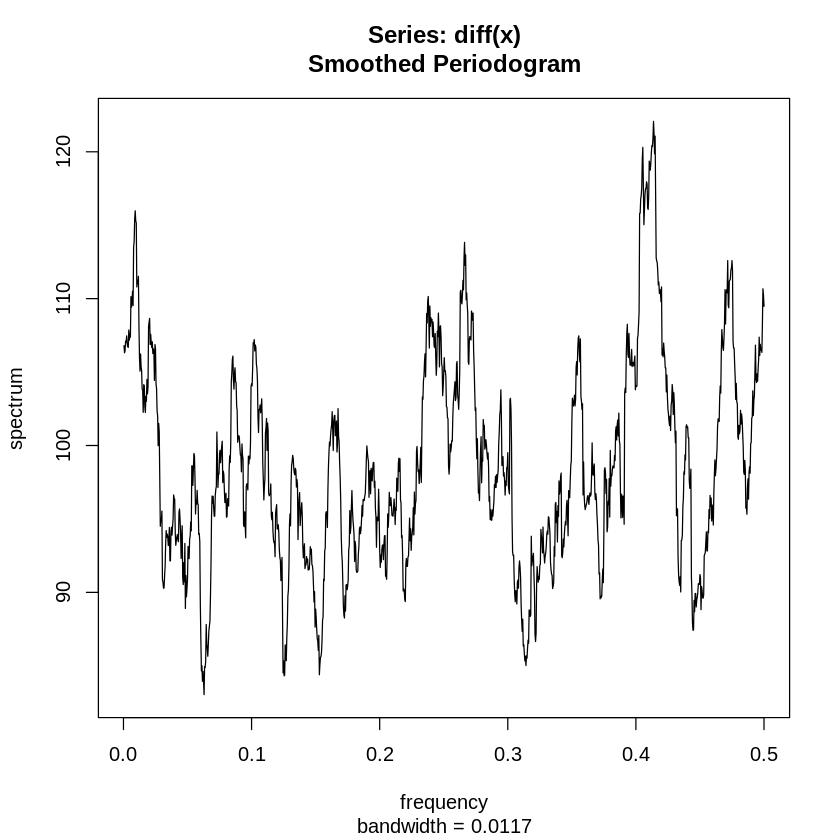

In [32]:
acf(diff(x), lag.max = 100)
pacf(diff(x))
spec.pgram(diff(x),log="no",taper=0)
spec.pgram(diff(x),log="no",taper=0,k=kernel("daniell",floor(sqrt(length(diff(x))))))

#### Let's try fitting to an ARIMA model
(and compare to fitting differences to an ARMA model)

In [36]:
arima( x, order=c(1,1,1) )


Call:
arima(x = x, order = c(1, 1, 1))

Coefficients:
          ar1      ma1
      -0.0046  -0.0044
s.e.   2.4729   2.4483

sigma^2 estimated as 98.82:  log likelihood = -8861.71,  aic = 17729.42

In [37]:
arima( diff(x), order=c(1,0,1) )


Call:
arima(x = diff(x), order = c(1, 0, 1))

Coefficients:
          ar1      ma1  intercept
      -0.0057  -0.0054     0.4493
s.e.   1.8502   1.8355     0.2011

sigma^2 estimated as 98.62:  log likelihood = -8859.22,  aic = 17726.44

In [38]:
ar( diff(x) )


Call:
ar(x = diff(x))


Order selected 0  sigma^2 estimated as  98.67

Overall, it's quite reasonable to think that (after differencing) this is white noise

(For stock prices, this makes sense: other than largescale trends that affect many stocks, it's unlikely there is much correlation (and hence ability to predict) in short-term prices, since if there is, investors will take advantage of it in a way that will reduce the correlation).

We can look at some white noises tests from the `itsmr` package:

Null hypothesis: Residuals are iid noise.
Test                        Distribution Statistic   p-value
Ljung-Box Q                Q ~ chisq(20)     11.48    0.9327
McLeod-Li Q                Q ~ chisq(20)     20.32    0.4378
Turning points T(T-1588.7)/20.6 ~ N(0,1)      1588    0.9742
Diff signs S      (S-1192)/14.1 ~ N(0,1)      1186    0.6705
Rank P      (P-1421460)/19418.6 ~ N(0,1)   1425920    0.8183


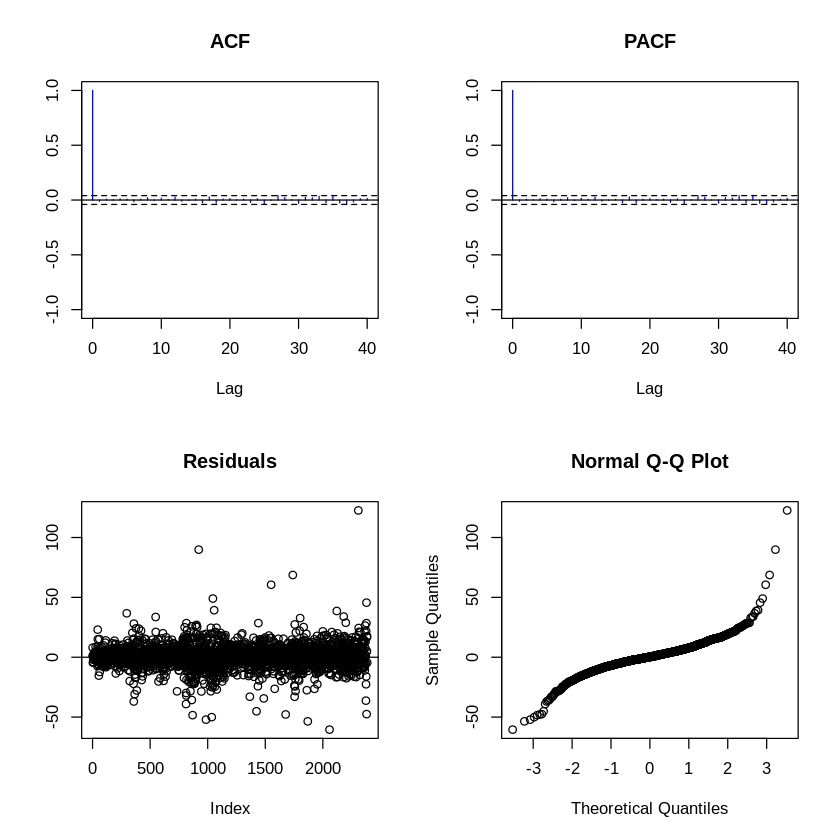

In [40]:
itsmr::test( diff(x) )

If we don't difference, then we definitely fail the white noise tests!

Null hypothesis: Residuals are iid noise.
Test                        Distribution Statistic   p-value
Ljung-Box Q                Q ~ chisq(20)   43708.1         0 *
McLeod-Li Q                Q ~ chisq(20)  42651.49         0 *
Turning points T(T-1589.3)/20.6 ~ N(0,1)      1196         0 *
Diff signs S    (S-1192.5)/14.1 ~ N(0,1)      1234    0.0033 *
Rank P    (P-1422652.5)/19430.8 ~ N(0,1)   2408159         0 *


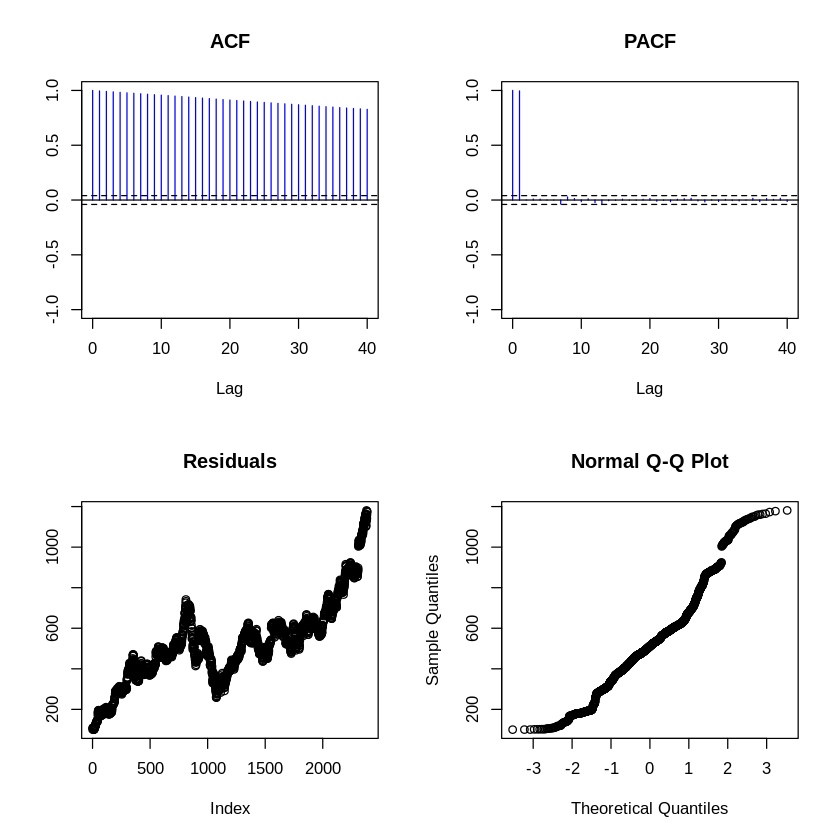

In [41]:
itsmr::test( x )

### Another data set: ice core readings of CO2

In [2]:
rm(list=ls())
link <- url('https://github.com/stephenbeckr/time-series-class/raw/main/Data/cfa_data.txt')
data <- read.csv(link, sep="\t",header=FALSE)
x    <- data[17000:25600,2]

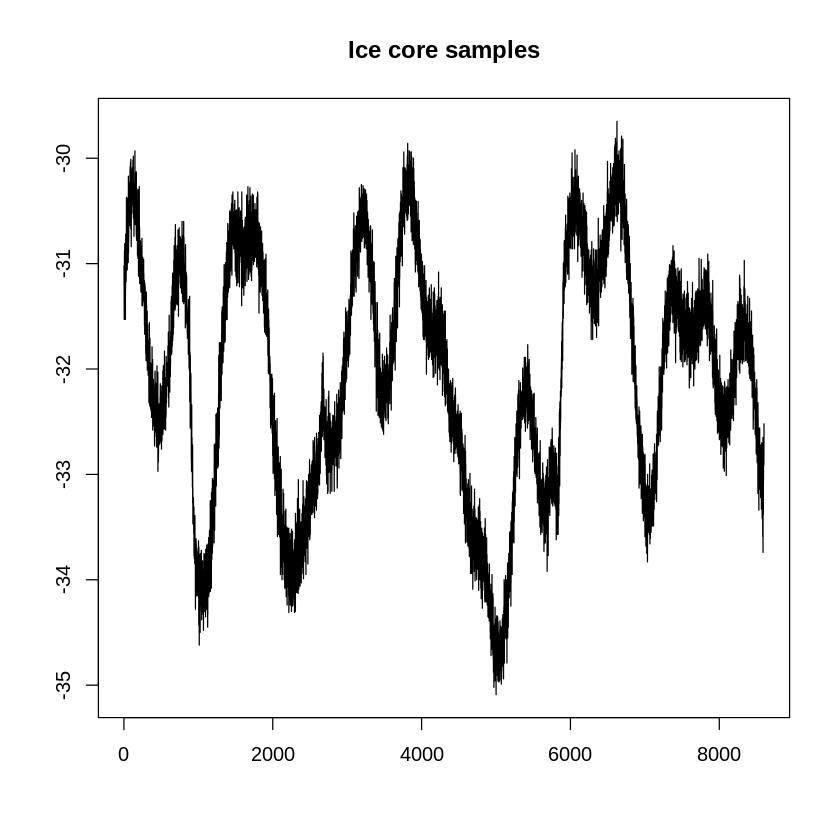

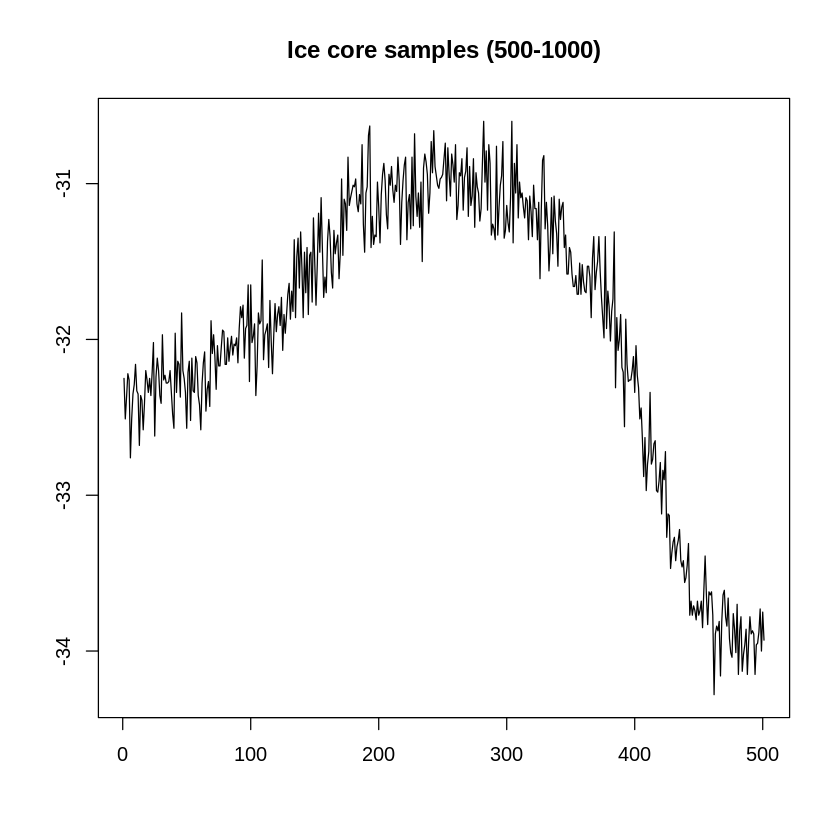

In [3]:
plot(x,type="l",xlab="",ylab="",main="Ice core samples")
plot(x[500:1000],type="l",xlab="",ylab="",main="Ice core samples (500-1000)")


Null hypothesis: Residuals are iid noise.
Test                        Distribution Statistic   p-value
Ljung-Box Q                Q ~ chisq(20)  161518.2         0 *
McLeod-Li Q                Q ~ chisq(20)  161622.1         0 *
Turning points T(T-5732.7)/39.1 ~ N(0,1)      5644    0.0233 *
Diff signs S      (S-4300)/26.8 ~ N(0,1)      4267    0.2177
Rank P    (P-18492150)/132956.6 ~ N(0,1)  18330787    0.2249


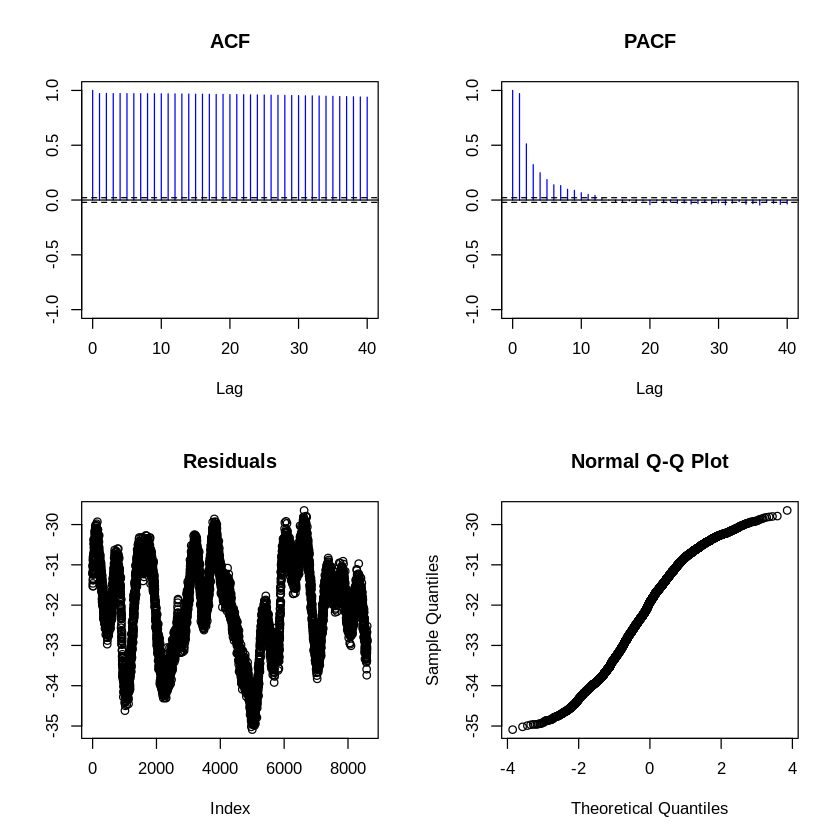

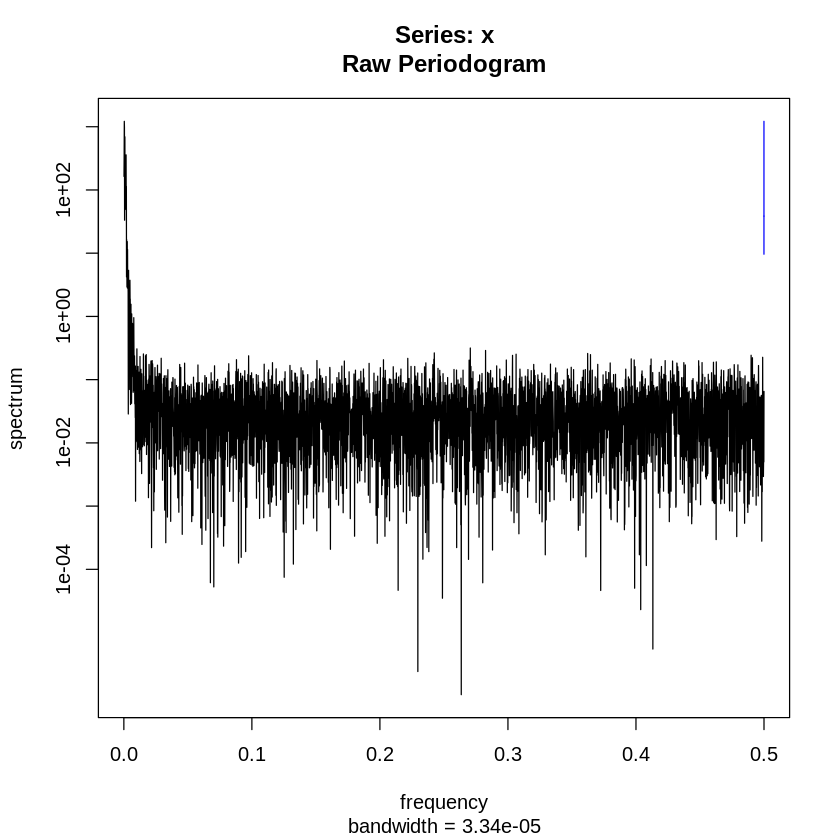

In [4]:
itsmr::test(x) # it's clearly not white noise...

# Periodogram
spec.pgram(x,log="yes",taper=0)

The ACF decays very slowly. Looking at it, there's a lot of slow moving structure, i.e., trend. In the short-term, this structure looks easy to predict.

As always, we could either try regress out the trend (but then we need some parametric model for the trend... would a linear or quadratic or sinusoid work here?) or we can difference.

Let's difference

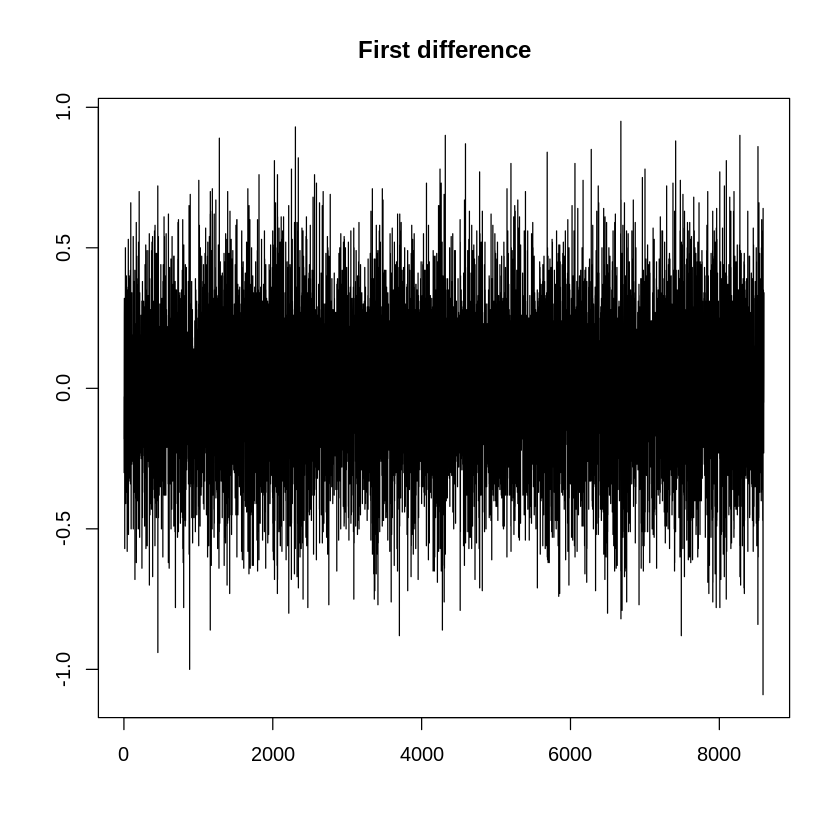

Null hypothesis: Residuals are iid noise.
Test                        Distribution Statistic   p-value
Ljung-Box Q                Q ~ chisq(20)   2369.44         0 *
McLeod-Li Q                Q ~ chisq(20)    705.37         0 *
Turning points T  (T-5732)/39.1 ~ N(0,1)      6274         0 *
Diff signs S    (S-4299.5)/26.8 ~ N(0,1)      4324    0.3601
Rank P    (P-18487850)/132933.5 ~ N(0,1)  18399079    0.5043


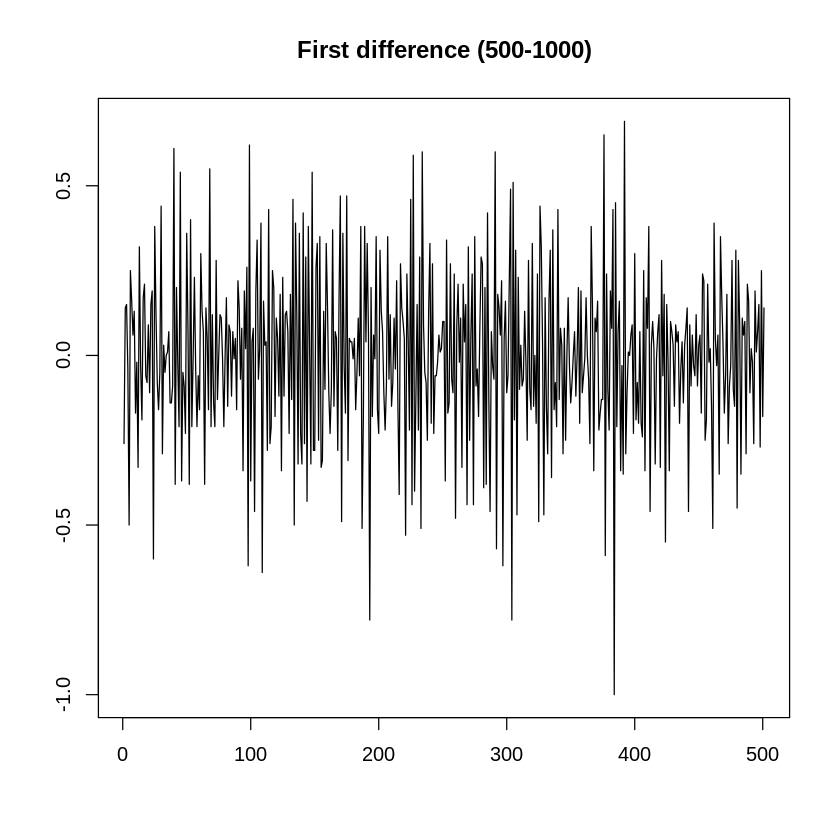

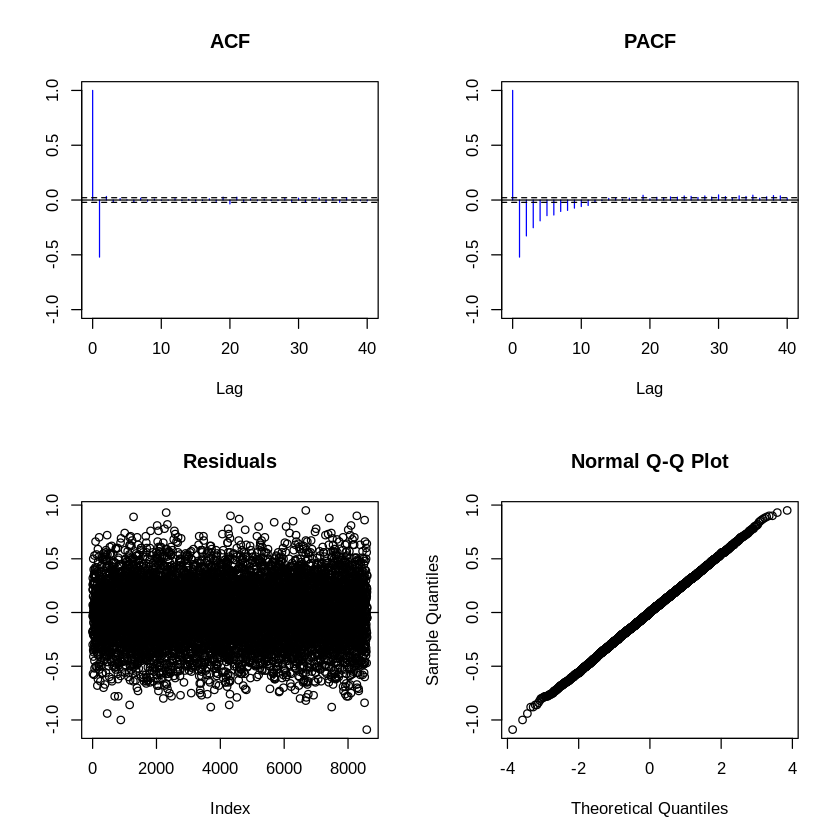

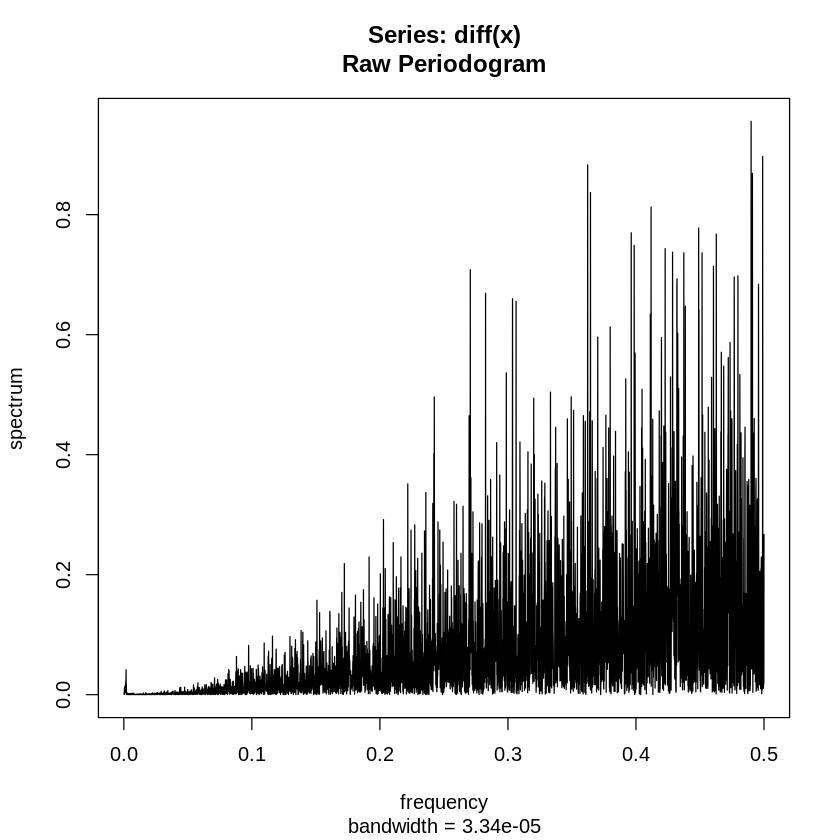

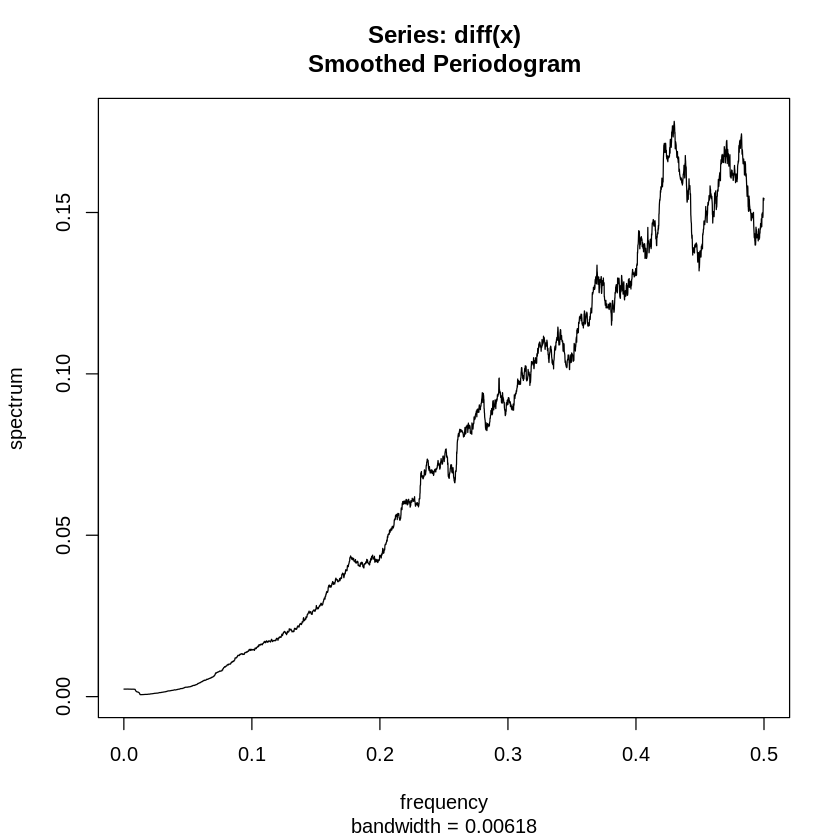

In [5]:
## First difference: Y_t = X_t - X_{t-1}
plot(diff(x),type="l",xlab="",ylab="",main="First difference")
plot(diff(x)[500:1000],type="l",xlab="",ylab="",main="First difference (500-1000)")

itsmr::test(diff(x))
spec.pgram(diff(x),log="no",taper=0)
spec.pgram(diff(x),log="no",taper=0,k=kernel("daniell",floor(sqrt(length(diff(x))))))


ACF and PACF look much better: mostly short-term correlation left.  It's clearly not white noise... so we can fit these differences to an ARMA process (or the original series to an ARIMA $d=1$ process)

From the ACF we see one strong component at lag 1 and not much else, suggesting a MA(1) model.  From the PACF we see several non-zero components for the first few lags, so this could be due to the MA(1) model (or something like an AR(5) model).

In [7]:
arima(x,order=c(1,1,1)) 
# Conclusion: the ar1 coefficient is small... next, let's try leaving it off


Call:
arima(x = x, order = c(1, 1, 1))

Coefficients:
          ar1      ma1
      -0.0788  -0.8197
s.e.   0.0121   0.0060

sigma^2 estimated as 0.04119:  log likelihood = 1511.19,  aic = -3016.38

In [8]:
arima(x,order=c(0,1,1)) # this improves the AIC


Call:
arima(x = x, order = c(0, 1, 1))

Coefficients:
          ma1
      -0.8367
s.e.   0.0047

sigma^2 estimated as 0.0414:  log likelihood = 1490.16,  aic = -2976.31

In [9]:
# And this is very nearly identical:
fit <- arima(diff(x),order=c(0,0,1),include.mean=FALSE)
fit


Call:
arima(x = diff(x), order = c(0, 0, 1), include.mean = FALSE)

Coefficients:
          ma1
      -0.8367
s.e.   0.0047

sigma^2 estimated as 0.0414:  log likelihood = 1490.16,  aic = -2976.32

As a check, we can simulate new realizations from this model and see if they look somewhat similar

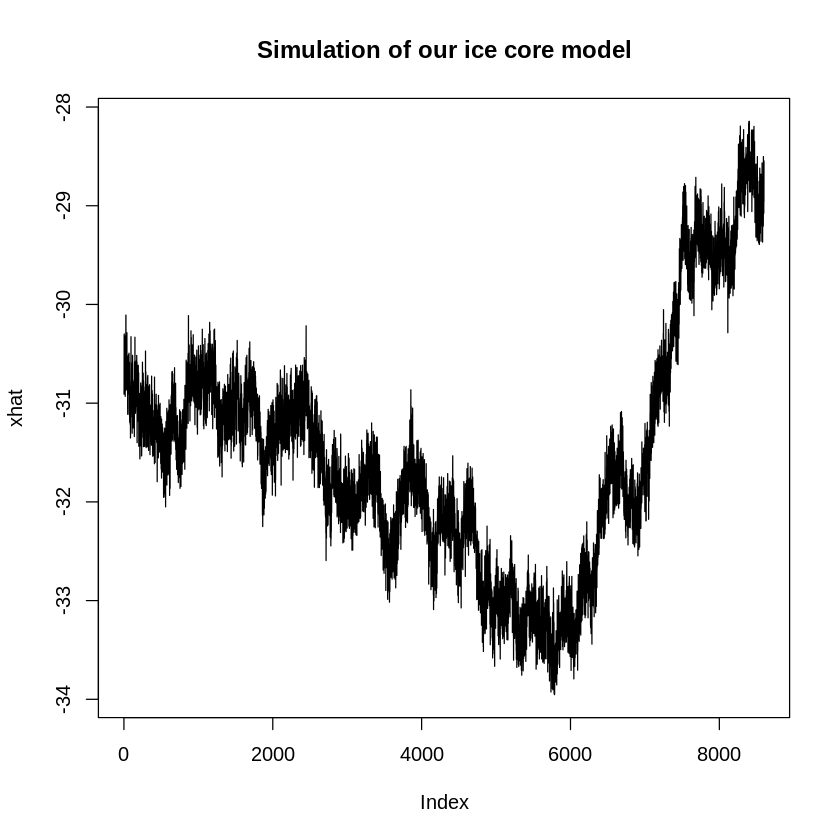

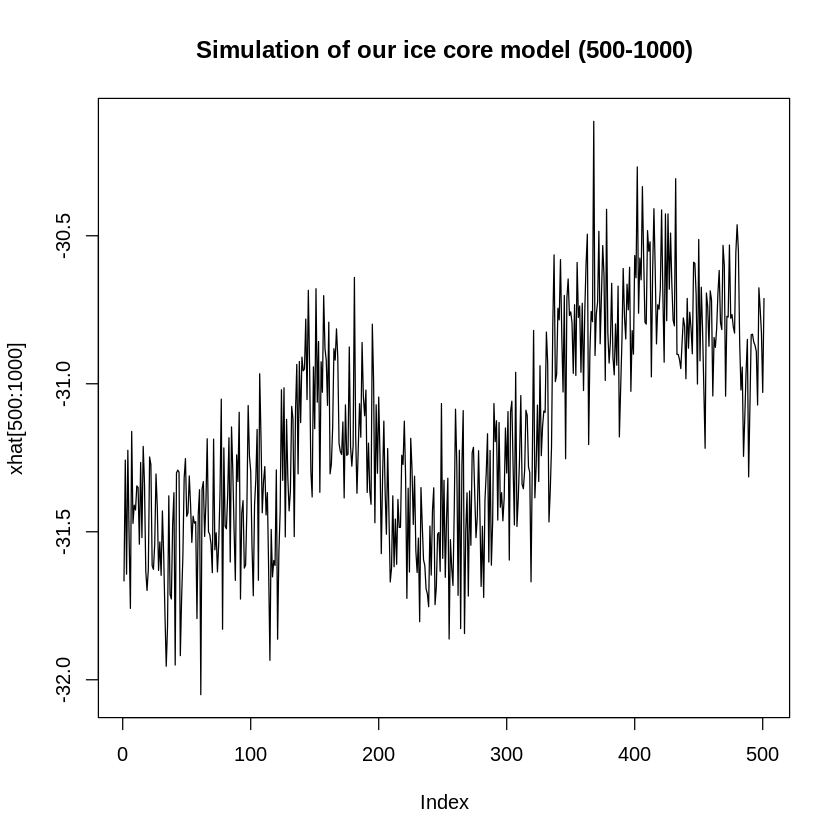

In [74]:
sim <- arima.sim( model=list(ma=coefficients(fit)), n=length(x)-1, sd=sqrt(fit$sigma2) )
# "sim" is the difference data, so we'll have to sum it ("integrate" it)

xhat <- cumsum(sim) + x[1]  # add in the right mean

plot( xhat ,type='l', main='Simulation of our ice core model' ) # cumsum is a cumulative sum; this is the integration
plot( xhat[500:1000] ,type='l', main='Simulation of our ice core model (500-1000)' ) 

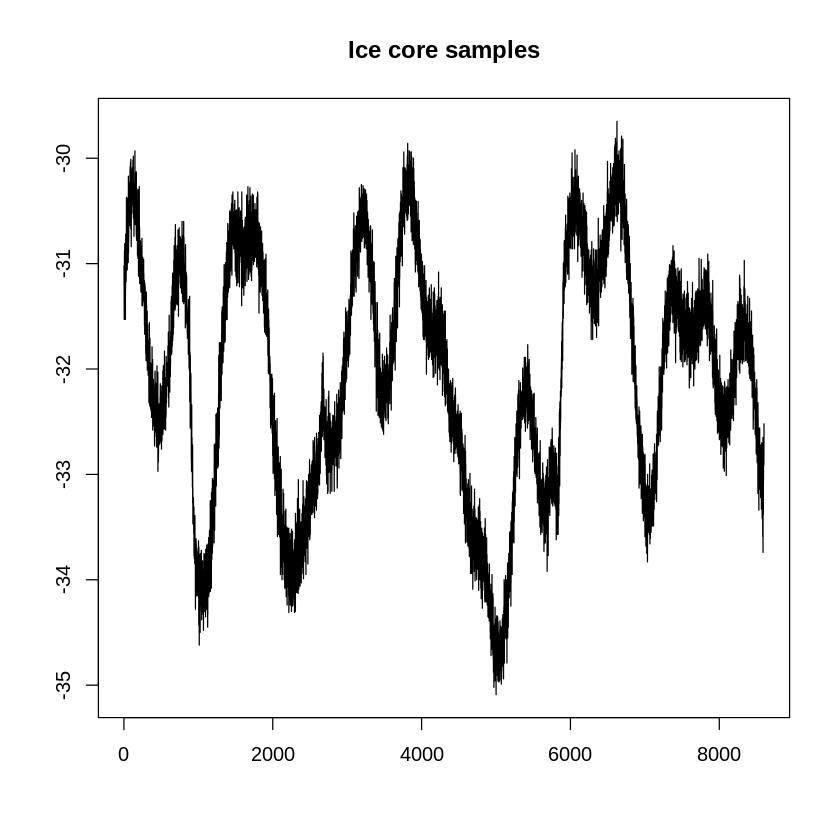

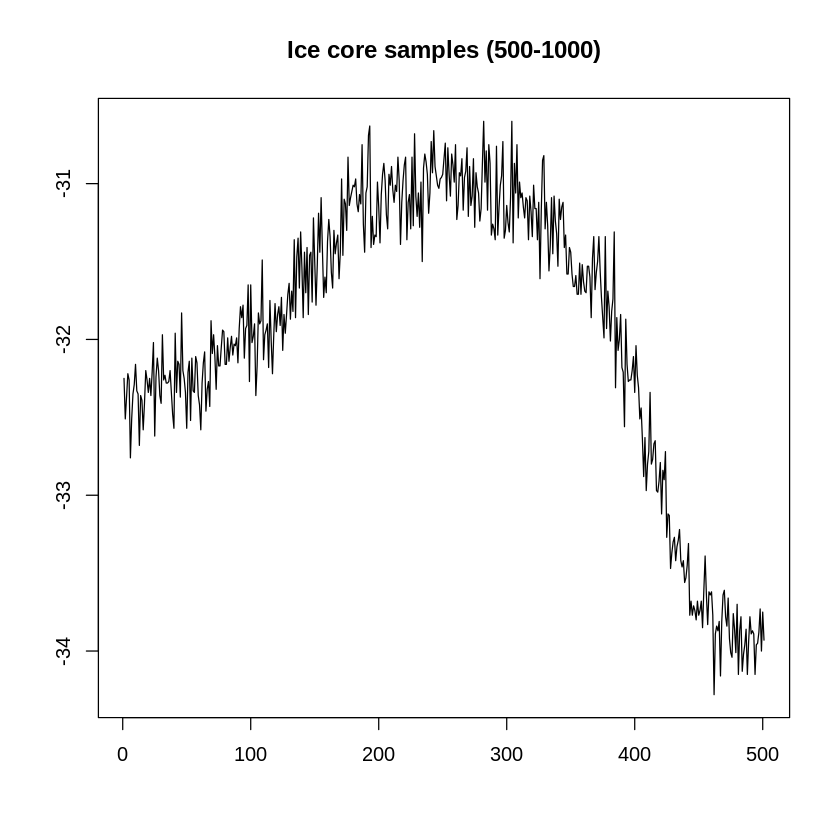

In [75]:
# and for our reference...
plot(x,type="l",xlab="",ylab="",main="Ice core samples")
plot(x[500:1000],type="l",xlab="",ylab="",main="Ice core samples (500-1000)")

#### What happens if we **over-difference**?

We should see the PACF start to have slow decay

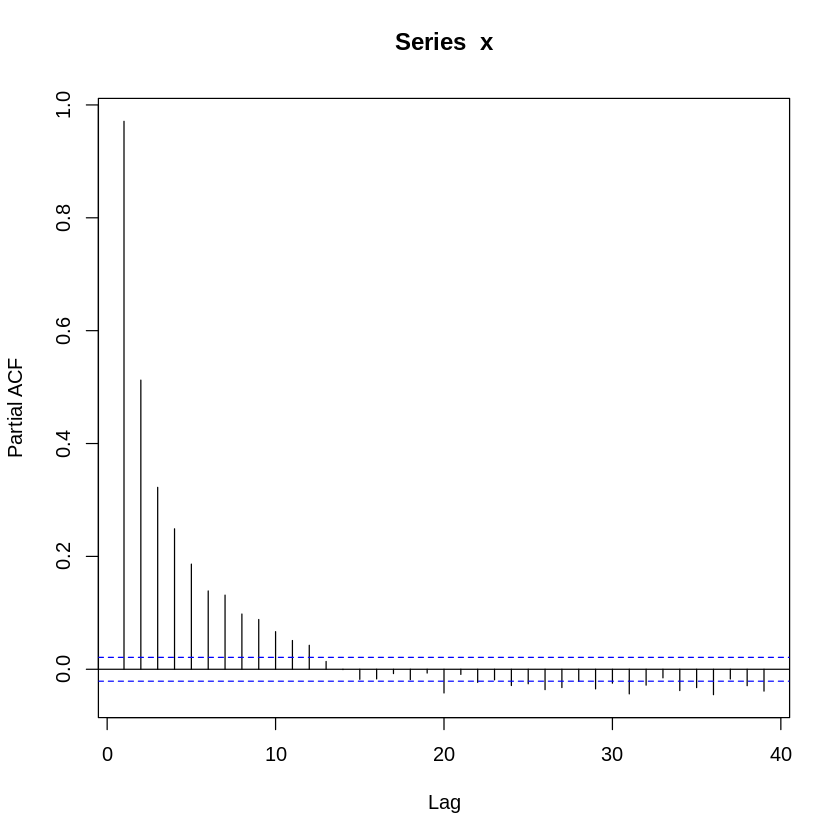

In [10]:
pacf(x)

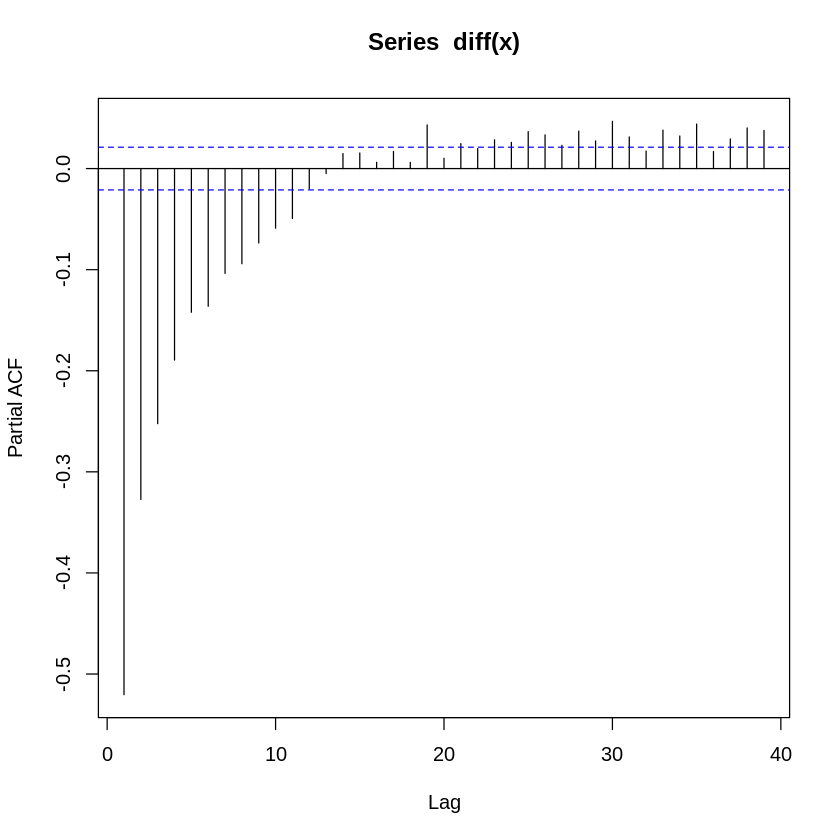

In [11]:
pacf(diff(x))

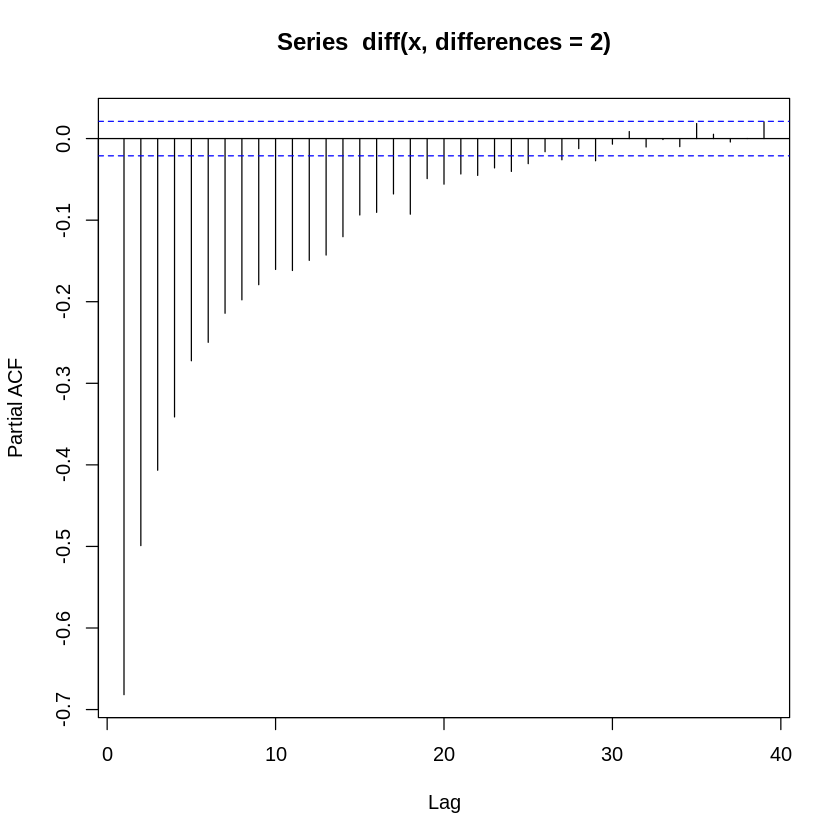

In [13]:
pacf(diff(x,differences=2))  # same as diff(diff(x))

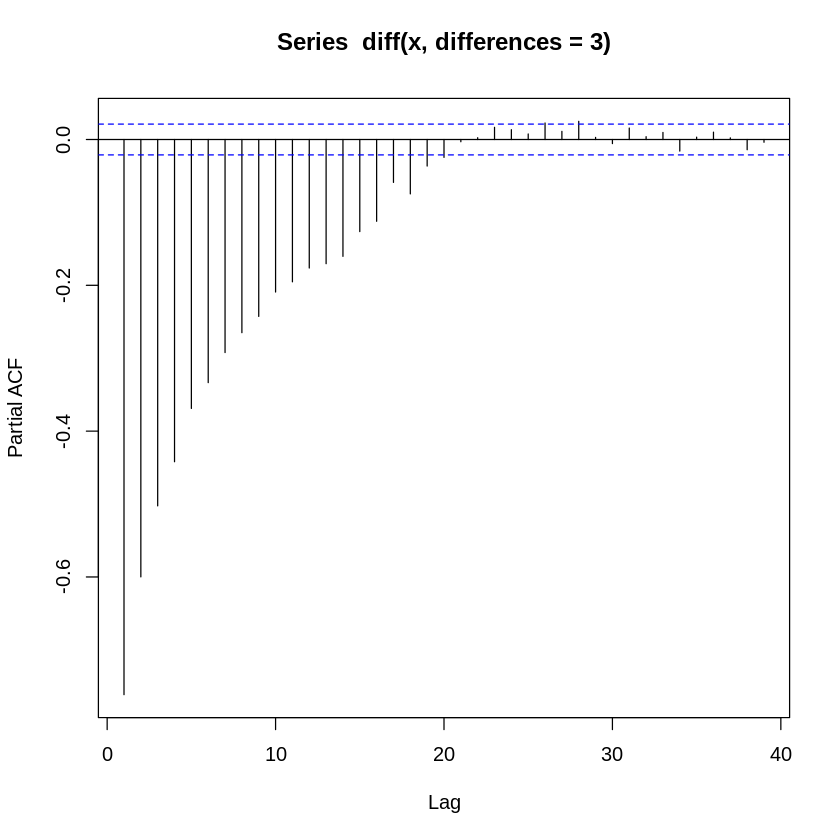

In [14]:
pacf(diff(x,differences=3))

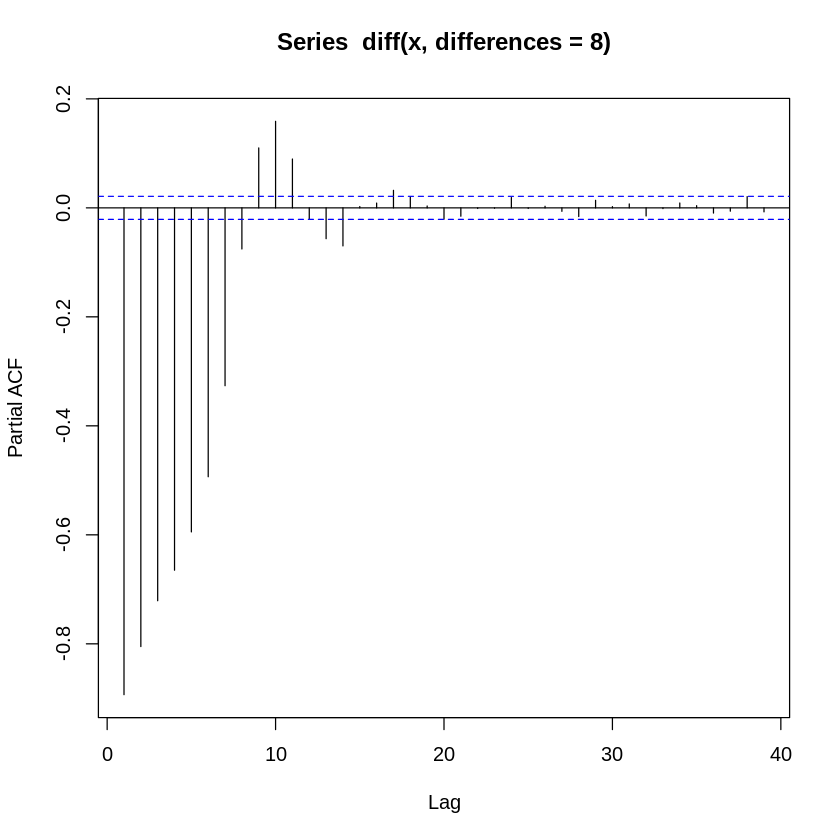

In [15]:
pacf(diff(x,differences=8))

The size of the 2nd PACF component gets closer and closer to the size of the 1st PACF component as we increase how many times we difference

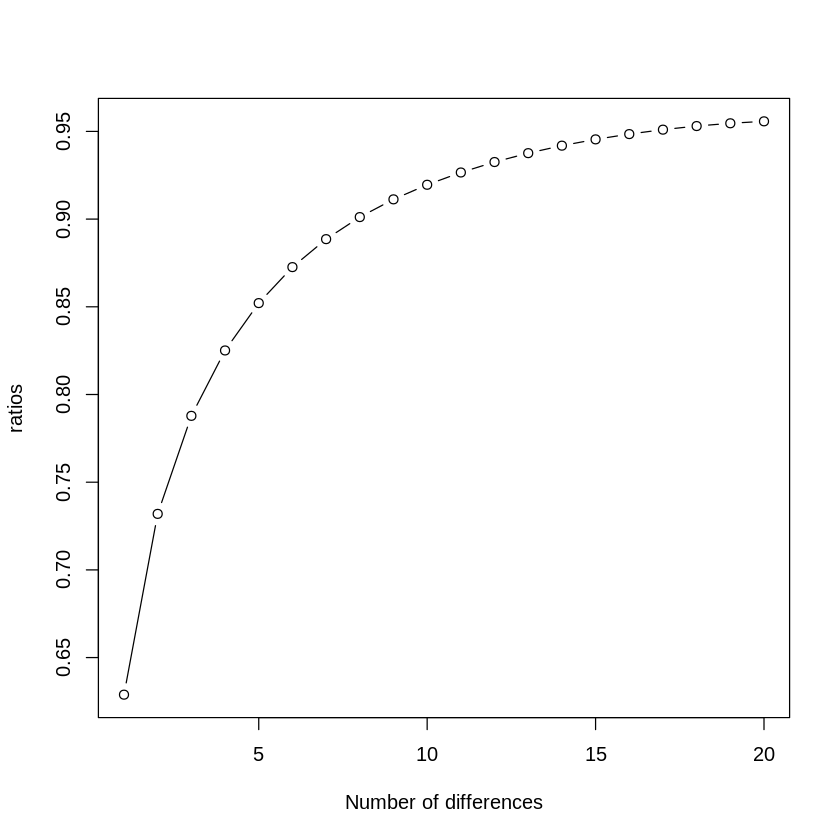

In [25]:
ratios <- rep(0,20)
for( d in 1:20 ){
  p <- pacf(diff(x,differences=d),plot=FALSE)
  ratios[d] <- p$acf[2]/p$acf[1] 
}
plot( ratios, type='b',xlab = "Number of differences")